Units used: GeV for masses, s for time, cm for distances

In [3]:
import glob
import matplotlib as mlib
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt
from numpy import loadtxt
import re
import csv
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.patches as mpatches

import sys
sys.path.insert(1, '/home/stasya/prj/alps-running/TdAlps-Internal/')
import TdAlps
from collections import OrderedDict

import scipy.integrate as integrate
import scipy.optimize as optimize

import csv

In [4]:
#Plotting settings

font = {
        'weight' : 'normal',
        'size'   : 16}

mlib.rc('font', **font)

In [5]:
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [6]:
constants={
    'InvGeVtocm': 1/(5.06 * 10**(13))
}

In [7]:
sm={
    'GF': 1.166*10**(-5),
    'sw': np.sqrt(0.231),
    'hbar': 6.582*10**(-25),
    'c': 3*10**10,
    'alpha': 1/137,
    'Vtb': 0.999,
    'Vts': 0.0404,
    'Xt': 1.469,
    'BrBtoKnunu+': 4.5*10**(-6),
    'NBBBaBar': 471*10**6,
    'NBBBelleII': 5*10**10,
    'me': 0.000511,
    'mmu': 0.1056,
    'mtau': 1.777,
    'mu': 2.2/1000,
    'md': 4.7/1000,
    'ms': 95/1000,
    'mc': 1.275,
    'mb': 4.18,
    'mt': 173,
    'mZ': 91.19,
    'mB+': 5.279,
    'mK+': 0.494,
    'tauB+': 1.638*10**(-12),
    'ctauB+': 3 * 10**10 * 1.638*10**(-12),
    'GammaB+': 6.582*10**(-25)/(10**(-12) * 1.638)
}

In [8]:
BelleIIparams={
    'gammaBoostB': 1.03029,
    'RCDC': 60, #cm
    'thetaCDCMin': np.deg2rad(17),
    'thetaCDCMax': np.deg2rad(150),
    'dres': 0.9,
    'NBBelleII': 5*10**10
}

In [9]:
def f(Lambda):
    return Lambda/(4 * np.pi)

In [10]:
def fz(t):
    tplus = (sm['mB+']+sm['mK+'])**2
    tminus = (sm['mB+']-sm['mK+'])**2
    tzero = tplus * (1-np.sqrt(1-tminus/tplus))
    return (np.sqrt(tplus-t) - np.sqrt(tplus-tzero))/(np.sqrt(tplus-t) + np.sqrt(tplus-tzero))

def formFactorFplusBplus(qsqr):
    tmp = 0.329
    tmp += -0.876 * (fz(qsqr) - fz(0))
    tmp += 0.006 * (fz(qsqr) - fz(0))**2
    tmp = tmp/(1-qsqr/5.325**2)
    return tmp

def formFactorFzeroBplus(qsqr):
    tmp = 0.329
    tmp += 0.195 * (fz(qsqr) - fz(0))
    tmp += -0.446 * (fz(qsqr) - fz(0))**2
    tmp = tmp/(1-qsqr/5.54**2)
    return tmp

## based on https://github.com/rrschaefer/alps (formulas taken from 2012.12272 and 1708.00443)

### Alps running implemented in https://github.com/TdAlps

In [11]:
def getLScoefficients(cff, cww, cbb, Lambda, mu):
    HC = OrderedDict()
    HC['Q'] = np.array([[cff,0,0],[0,cff,0],[0,0,cff]])
    HC['u'] = np.array([[-cff,0,0],[0,-cff,0],[0,0,-cff]])
    HC['d'] = np.array([[-cff,0,0],[0,-cff,0],[0,0,-cff]])
    HC['L'] = np.array([[cff,0,0],[0,cff,0],[0,0,cff]])
    HC['e'] = np.array([[-cff,0,0],[0,-cff,0],[0,0,-cff]])
    HC['GG'] = 0
    HC['WW'] = cww
    HC['BB'] = cbb
    return TdAlps.RunRotateMatchRun(HC, Lambda, mu, 3)


def getCuu(cff, cww, cbb, Lambda, mu):
    coeffs = getLScoefficients(cff, cww, cbb, Lambda, mu)
    return coeffs['U'][0][0]-coeffs['u'][0][0]

def getCcc(cff, cww, cbb, Lambda, mu):
    coeffs = getLScoefficients(cff, cww, cbb, Lambda, mu)
    return coeffs['U'][1][1]-coeffs['u'][1][1]

def getCtt(cff, cww, cbb, Lambda, mu):
    coeffs = getLScoefficients(cff, cww, cbb, Lambda, mu)
    return coeffs['U'][2][2]-coeffs['u'][2][2]

def getCdd(cff, cww, cbb, Lambda, mu):
    coeffs = getLScoefficients(cff, cww, cbb, Lambda, mu)
    return coeffs['D'][0][0]-coeffs['d'][0][0]

def getCss(cff, cww, cbb, Lambda, mu):
    coeffs = getLScoefficients(cff, cww, cbb, Lambda, mu)
    return coeffs['D'][1][1]-coeffs['d'][1][1]

def getCbb(cff, cww, cbb, Lambda, mu):
    coeffs = getLScoefficients(cff, cww, cbb, Lambda, mu)
    return coeffs['D'][2][2]-coeffs['d'][2][2]

def getCGG(cff, cww, cbb, Lambda, mu):
    coeffs = getLScoefficients(cff, cww, cbb, Lambda, mu)
    return coeffs['GG']

def getCgg(cff, cww, cbb, Lambda, mu):
    coeffs = getLScoefficients(cff, cww, cbb, Lambda, mu)
    return coeffs['gamgam']

def getCee(cff, cww, cbb, Lambda, mu):
    coeffs = getLScoefficients(cff, cww, cbb, Lambda, mu)
    return coeffs['E'][0][0]-coeffs['e'][0][0]

def getCmumu(cff, cww, cbb, Lambda, mu):
    coeffs = getLScoefficients(cff, cww, cbb, Lambda, mu)
    return coeffs['E'][1][1]-coeffs['e'][1][1]

def getCtautau(cff, cww, cbb, Lambda, mu):
    coeffs = getLScoefficients(cff, cww, cbb, Lambda, mu)
    return coeffs['E'][2][2]-coeffs['e'][2][2]

def getCbs(cff, cww, cbb, Lambda, mu):
    coeffs = getLScoefficients(cff, cww, cbb, Lambda, mu)
    return coeffs['D'][2][1]-coeffs['d'][2][1]

def getAlphaEM(cff, cww, cbb, Lambda, mu):
    coeffs = getLScoefficients(cff, cww, cbb, Lambda, mu)
    return coeffs['aEM']

def getAlphaS(cff, cww, cbb, Lambda, mu):
    coeffs = getLScoefficients(cff, cww, cbb, Lambda, mu)
    return coeffs['a3']


def readCuu(coeffs):
    return coeffs['U'][0][0]-coeffs['u'][0][0]

def readCcc(coeffs):
    return coeffs['U'][1][1]-coeffs['u'][1][1]

def readCtt(coeffs):
    return coeffs['U'][2][2]-coeffs['u'][2][2]

def readCdd(coeffs):
    return coeffs['D'][0][0]-coeffs['d'][0][0]

def readCss(coeffs):
    return coeffs['D'][1][1]-coeffs['d'][1][1]

def readCbb(coeffs):
    return coeffs['D'][2][2]-coeffs['d'][2][2]

def readCGG(coeffs):
    return coeffs['GG']

def readCgg(coeffs):
    return coeffs['gamgam']

def readCee(coeffs):
    return coeffs['E'][0][0]-coeffs['e'][0][0]

def readCmumu(coeffs):
    return coeffs['E'][1][1]-coeffs['e'][1][1]

def readCtautau(coeffs):
    return coeffs['E'][2][2]-coeffs['e'][2][2]

def readCbs(coeffs):
    return coeffs['D'][2][1]-coeffs['d'][2][1]

def readAlphaEM(coeffs):
    return coeffs['aEM']

def readAlphaS(coeffs):
    return coeffs['a3']

def printLowScaleCoef(coeffs):
    print("readCuu = {0}\n readCcc = {1}\n readCdd = {2}\n readCss = {3}\n readCbb = {4}\n".format(readCuu(coeffs),readCcc(coeffs),readCdd(coeffs),readCss(coeffs),readCbb(coeffs)))  

In [12]:
testCoeff= getLScoefficients(1, 0.5, 0, 10**3, 5)#(cff, cww, cbb, Lambda, mu)

In [13]:
readCbs(getLScoefficients(1, 0, 0, 10**3, 5))

(0.0006075064977644085+1.1376652072672074e-05j)

In [14]:
getCbs(1, 0.5, 0, 10**3, 5)

(0.0006093904735977875+1.141193290941793e-05j)

In [15]:
readCgg(testCoeff)

(0.5+0j)

In [16]:
readAlphaEM(testCoeff)

(0.009355856842486333+0j)

In [17]:
printLowScaleCoef(testCoeff)

readCuu = (1.8074145610334433-1.236002685836065e-23j)
 readCcc = (1.8074145610334433-1.236002685836065e-23j)
 readCdd = (1.9849201641117094-1.6989130428214282e-21j)
 readCss = (1.9848961320794243+3.3757792145663177e-21j)
 readCbb = (1.9702061679936684-1.2352574450883817e-23j)



### ALP and B-> Ka decay rates

In [18]:
def nq(ma):
    if ma>2*sm['mt']:
        return 6
    elif ma>=2*sm['mb']:
        return 5
    elif ma>=2*sm['mc']:
        return 4
    elif ma>=2*sm['ms']:
        return 3
    elif ma>=2*sm['md']:
        return 2
    elif ma>=2*sm['mu']:
        return 1
    else:
        return 0

def B2(tau):
    return 1-(tau-1)*funcB(tau)**2

# (14) in 2012.12272
def B1(tau):
    return 1-tau*funcB(tau)**2


def funcB(tau):
    if tau>=1:
        return np.arcsin(1/np.sqrt(tau))
    else:
        return np.pi/2 + 1j/2 * np.log((1+np.sqrt(1-tau))/(1-np.sqrt(1-tau)))

In [19]:
def Gammaatoll(ma, cll, ml, Lambda):
    if ma <= 2 * ml:
        return 0
    gamma = ml**2 * abs(cll)**2 * np.sqrt(ma**2 - 4 * ml**2) / (8 * np.pi * Lambda**2) 
    if gamma.imag  != 0:
        if gamma.imag/gamma.real > 10**-10:
            print("The Decay rate to leptons with mass " + str(ml) + " is complex: " + str(gamma))
    return float(gamma)

def Gammaatoqq(ma, cqq, mq, Lambda):
    if ma <= 2 * mq:
        return 0
    gamma = 3 * mq**2 * abs(cqq)**2 * np.sqrt(ma**2 - 4 * mq**2) / (8 * np.pi * Lambda**2)
    if gamma.imag  != 0:
        if gamma.imag/gamma.real > 10**-10:
            print("The Decay rate to quarks with mass " + str(mq) + " is complex: " + str(gamma))
    return float(gamma)

def Gammaatogamgam(ma, coeffs, Lambda):
    cgamgam = readCgg(coeffs)
    alphaEM = readAlphaEM(coeffs)
    effcgg = cgamgam
    if ma >= sm['mZ']:
        effcgg += 2 * alphaEM/np.pi * coeffs['WW']/sm['sw']**2 * B2(4*sm['mW']**2/ma**2)
        effcgg += 3 * (2/3)**2 * readCtt(coeffs) * B1(4*sm['mt']**2/ma**2)
    if ma >= sm['mc']:
        effcgg += 3 * (2/3)**2 * readCcc(coeffs) * B1(4*sm['mc']**2/ma**2) 
    if ma >= sm['mu']:
        effcgg += 3 * (2/3)**2 * readCuu(coeffs) * B1(4*sm['mu']**2/ma**2)
    if ma >= sm['mb']:
        effcgg += 3 * (-1/3)**2 * readCbb(coeffs) * B1(4*sm['mb']**2/ma**2)
    if ma >= sm['ms']:
        effcgg += 3 * (-1/3)**2 * readCss(coeffs) * B1(4*sm['ms']**2/ma**2)
    if ma >= sm['md']:
        effcgg += 3 * (-1/3)**2 * readCdd(coeffs) * B1(4*sm['md']**2/ma**2)
    if ma >= sm['me']:
        effcgg += readCee(coeffs) * B1(4*sm['me']**2/ma**2)
    if ma >= sm['mmu']:
        effcgg += readCmumu(coeffs) * B1(4*sm['mmu']**2/ma**2)
    if ma >= sm['mtau']:
        effcgg += readCtautau(coeffs) * B1(4*sm['mtau']**2/ma**2)
    gamma = abs(effcgg)**2 * alphaEM**2 * ma**3 /(4 * np.pi * Lambda**2) 
    if gamma.imag  != 0:
        if gamma.imag/gamma.real > 10**-10:
            print("The Decay rate to photons is complex: " + str(gamma))
    return float(gamma)

def GammaatogamgamMy(ma, coeffs, Lambda):
    cgamgam = readCgg(coeffs)
    alphaEM = readAlphaEM(coeffs)
    effcgg = cgamgam
    # eq. (47) in 2012.12272
    if ma>sm['me']:
        effcgg +=readCee(coeffs) * B1(4*sm['me']**2/ma**2) 
    if ma>sm['mmu']:
        effcgg +=readCmumu(coeffs) * B1(4*sm['mmu']**2/ma**2) 
    if ma>sm['mtau']:
        effcgg +=readCtautau(coeffs) * B1(4*sm['mtau']**2/ma**2)
        
    if ma>sm['mu']:
        effcgg += 3 * (2/3)**2 * readCuu(coeffs) * B1(4*sm['mu']**2/ma**2) 
    if ma>sm['mc']:
        effcgg += 3 * (2/3)**2 * readCdd(coeffs) * B1(4*sm['mc']**2/ma**2) 
    if ma>sm['mt']:
        effcgg += 3 * (2/3)**2 * readCtt(coeffs) * B1(4*sm['mt']**2/ma**2) 
        
    if ma>sm['md']:
        effcgg += 3 * (1/3)**2 * readCdd(coeffs) * B1(4*sm['md']**2/ma**2) 
    if ma>sm['ms']:
        effcgg += 3 * (1/3)**2 * readCss(coeffs) * B1(4*sm['ms']**2/ma**2) 
    if ma>sm['mb']:
        effcgg += 3 * (1/3)**2 * readCbb(coeffs) * B1(4*sm['mb']**2/ma**2) 
        
    if ma >= sm['mZ']:
        effcgg += 2 * alphaEM/np.pi * coeffs['WW']/sm['sw']**2 * B2(4*sm['mW']**2/ma**2)
        
    # eq.(46) in 2012.12272
    gamma = abs(effcgg)**2 * alphaEM**2 * ma**3 /(64 * np.pi * f(Lambda)**2) 
    if gamma.imag  != 0:
        if gamma.imag/gamma.real > 10**-10:
            print("The Decay rate to photons is complex: " + str(gamma))
    return float(gamma)
    

def Gammaatohad(ma, coeffs, Lambda):
    if ma <= 1:
        return 0
    alphaS = readAlphaS(coeffs)
    cGGeff = readCGG(coeffs)
    cGGeff += 1/2 * readCuu(coeffs) * B1(4*sm['mu']**2/ma**2)
    cGGeff += 1/2 * readCdd(coeffs) * B1(4*sm['md']**2/ma**2)
    cGGeff += 1/2 * readCss(coeffs) * B1(4*sm['ms']**2/ma**2)
#     if ma>2*sm['mc']:
#         cGGeff += 1/2 * readCcc(coeffs) * B1(4*sm['mc']**2/ma**2)
#     if ma>2*sm['mb']:
#         cGGeff += 1/2 * readCbb(coeffs) * B1(4*sm['mb']**2/ma**2)
#     if ma >= sm['mZ']:
#         cGGeff += 1/2 * readCtt(coeffs) * B1(4*sm['mt']**2/ma**2)
#     nQ = nq(ma)
    nQ = 3
#    gamma = abs(cGGeff)**2 * 32 * np.pi * alphaS**2 * ma**3 * (1 + (97/4-7*nQ/6) * alphaS/np.pi) /Lambda**2
    gamma = abs(cGGeff)**2 * alphaS**2 * ma**3 * (1 + (97/4-7*nQ/6) * alphaS/np.pi) * 2/(np.pi * Lambda**2)
    gamma += Gammaatoqq(ma, readCuu(coeffs), sm['mu'], Lambda)
    gamma += Gammaatoqq(ma, readCdd(coeffs), sm['md'], Lambda)
    gamma += Gammaatoqq(ma, readCss(coeffs), sm['ms'], Lambda)
    if gamma.imag  != 0:
        if gamma.imag/gamma.real > 10**-10:
            print("The Decay rate to hadrons is complex: " + str(gamma))
    return float(gamma)

#Old formula
def GammaatohadMyCheck(ma, coeffs, Lambda):
    if ma <= 1:
        return 0
    alphaS = readAlphaS(coeffs)
    cGGeff = readCGG(coeffs)
    
    # eq.(13) in 2012.12272
    
    cGGeff += 1/2 * readCuu(coeffs) * B1(4*sm['mu']**2/ma**2) * np.heaviside(ma-sm['mu'],1)\
            + 1/2 * readCdd(coeffs) * B1(4*sm['md']**2/ma**2) * np.heaviside(ma-sm['md'],1)\
            + 1/2 * readCss(coeffs) * B1(4*sm['ms']**2/ma**2) * np.heaviside(ma-sm['ms'],1)\
            + 1/2 * readCcc(coeffs) * B1(4*sm['mc']**2/ma**2) * np.heaviside(ma-sm['mc'],1)\
            + 1/2 * readCbb(coeffs) * B1(4*sm['mb']**2/ma**2) * np.heaviside(ma-sm['mb'],1)\
            #+ 1/2 * readCtt(coeffs) * B1(4*sm['mt']**2/ma**2) * np.heaviside(ma-sm['mZ'],1)\
        
    # eq.(29) in 1708.00443 with nq=3 light quarks
    gamma = abs(cGGeff)**2 * 32 * np.pi * alphaS**2 * ma**3 * \
            (1 + (97/4-7*nq(ma)/6) * alphaS/np.pi)/Lambda**2
    if gamma.imag  != 0:
        if gamma.imag/gamma.real > 10**-10:
            print("The Decay rate to hadrons is complex: " + str(gamma))
    return float(gamma)

In [20]:
print(Gammaatogamgam(0.5, testCoeff, 10**3),GammaatogamgamMy(0.5, testCoeff, 10**3))

6.52695168444915e-11 6.44184310705369e-10


<ipython-input-19-de56bdf3d9c0>:46: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)
<ipython-input-19-de56bdf3d9c0>:82: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)


In [21]:
print(Gammaatogamgam(5, testCoeff, 10**3),GammaatogamgamMy(5, testCoeff, 10**3))

1.2363309318937695e-07 1.2788374334017266e-06


<ipython-input-19-de56bdf3d9c0>:46: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)
<ipython-input-19-de56bdf3d9c0>:82: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)


In [22]:
print(Gammaatohad(3, testCoeff, 10**3),GammaatohadMyCheck(3, testCoeff, 10**3))

1.6073220855935154e-05 0.0021527755294098645


<ipython-input-19-de56bdf3d9c0>:109: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)
<ipython-input-19-de56bdf3d9c0>:133: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)


In [23]:
def Gammaa(ma, cff, cww, cbb, Lambda):
    lscs = getLScoefficients(cff, cww, cbb, Lambda, ma)
    GammaTot = 0
    if ma>2*sm['me']:
        GammaTot += Gammaatoll(ma,readCee(lscs),sm['me'],Lambda)
    if ma>2*sm['mmu']:
        GammaTot += Gammaatoll(ma,readCmumu(lscs),sm['mmu'],Lambda)
    if ma>2*sm['mtau']:
        GammaTot += Gammaatoll(ma,readCtautau(lscs),sm['mtau'],Lambda)
    if ma>2*sm['mc']:
        GammaTot += Gammaatoqq(ma,readCcc(lscs),sm['mc'],Lambda)
    if ma>2*sm['mb']:
        GammaTot += Gammaatoqq(ma,readCbb(lscs),sm['mb'],Lambda)
    if ma>1:
        GammaTot += Gammaatohad(ma,lscs,Lambda)
    GammaTot += Gammaatogamgam(ma,lscs,Lambda)
    if GammaTot.imag  != 0:
        print("The Decay rate to hadrons is complex: " + str(GammaTot))
    return float(GammaTot)

In [24]:
def BrBtoKaplus(ma, cbs, Lambda):
    return abs(cbs)**2/(16 * np.pi * Lambda**2) * abs(formFactorFzeroBplus(ma))**2* (sm['mB+']**2\
    -sm['mK+'])**2/sm['mB+']**3 * np.sqrt(sm['mB+']**4+sm['mK+']**4+ma**4-2*(sm['mB+']**2 * sm['mK+']**2 \
                                    + sm['mK+']**2 * ma**2 + ma**2 * sm['mB+']**2))/sm['hbar']*sm['tauB+']

def BrBtoKaplusMyCheck(ma, cbs, Lambda):
    return abs(cbs)**2/(16 * np.pi * Lambda**2) * abs(formFactorFzeroBplus(ma))**2* (sm['mB+']**2\
    -sm['mK+'])**2/sm['mB+']**3 * np.sqrt(sm['mB+']**4+sm['mK+']**4+ma**4-2*(sm['mB+']**2 * sm['mK+']**2 \
                                    + sm['mK+']**2 * ma**2 + ma**2 * sm['mB+']**2))/sm['GammaB+']

In [25]:
def ctaua(ma, cff, cww, cbb, Lambda):
    gamma = Gammaa(ma,cff,cww,cbb,Lambda)
    if gamma == 0:
        print("The decay width of a with ma=" + str(ma) + "GeV and cff=" + str(cff) + ", cWW="+ str(cww)+ ", cBB=" + str(cbb) + " is zero.")
        return 0
    return sm['c']*sm['hbar']/gamma

In [26]:
BrBtoKaplus(2, 1, 10**3)

721645.0581140692

In [27]:
BrBtoKaplusMyCheck(0.3, 1, 10**3)

764400.4958397369

In [28]:
Gammaa(3, 1, 0, 0, 10**3)

<ipython-input-19-de56bdf3d9c0>:109: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)
<ipython-input-19-de56bdf3d9c0>:46: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)


2.5384445624301206e-05

### ALP branching ratios

In [29]:
# def brsALP(cQ,cu,cd,cL,ce,cGG,cWW,cBB,title,Lambda,br=True):
#     with HiddenPrints():
#         HC = OrderedDict()
#         HC['Q'] = np.array([[cQ,0,0],[0,cQ,0],[0,0,cQ]])
#         HC['u'] = np.array([[cu,0,0],[0,cu,0],[0,0,cu]])
#         HC['d'] = np.array([[cd,0,0],[0,cd,0],[0,0,cd]])
#         HC['L'] = np.array([[cL,0,0],[0,cL,0],[0,0,cL]])
#         HC['e'] = np.array([[ce,0,0],[0,ce,0],[0,0,ce]])
#         HC['GG'] = cGG
#         HC['WW'] = cWW
#         HC['BB'] = cBB

#         maList = list((i*10**(exp-2) for exp in range(-3, 2) for i in range(10, 100)))
#         brs = [[],[],[],[],[],[],[],[]]
#         for ma in maList:
#             lscs = TdAlps.RunRotateMatchRun(HC, Lambda, ma, 3)
#             brs[0].append(Gammaatoll(ma,readCee(lscs),sm['me'],Lambda))
#             brs[1].append(Gammaatoll(ma,readCmumu(lscs),sm['mmu'],Lambda))
#             try:
#                 ctautau = readCtautau(lscs)
#             except IndexError:
#                 ctautau = 0
#             brs[2].append(Gammaatoll(ma,ctautau,sm['mtau'],Lambda))
#             try:
#                 ccc = readCcc(lscs)
#             except IndexError:
#                 ccc = 0
#             brs[3].append(Gammaatoqq(ma,ccc,sm['mc'],Lambda))
#             try:
#                 cbb = readCbb(lscs)
#             except IndexError:
#                 cbb = 0
#             brs[4].append(Gammaatoqq(ma,cbb,sm['mb'],Lambda))
#             brs[5].append(Gammaatogamgam(ma,lscs,Lambda))
#             brs[6].append(Gammaatohad(ma,lscs,Lambda))
#             brs[7].append(brs[0][-1]+brs[1][-1]+brs[2][-1]+brs[3][-1]+brs[4][-1]+brs[5][-1]+brs[6][-1])
#             if (br):
#                 brs[0][-1] = brs[0][-1]/brs[7][-1]
#                 brs[1][-1] = brs[1][-1]/brs[7][-1]
#                 brs[2][-1] = brs[2][-1]/brs[7][-1]
#                 brs[3][-1] = brs[3][-1]/brs[7][-1]
#                 brs[4][-1] = brs[4][-1]/brs[7][-1]
#                 brs[5][-1] = brs[5][-1]/brs[7][-1]
#                 brs[6][-1] = brs[6][-1]/brs[7][-1]

#         fig, ax = plt.subplots() 
#         ax.set_xscale('log')
#         ax.set_yscale('log')
#         ax.set_xlabel('ma [GeV]')
#         if (br):
#             ax.set_ylim([2*10**-4,2.5])
#             ax.set_xlim([5*10**-4,11])
#             ax.set_ylabel('Branching ratio Br(a->X)')
#             ax.plot([maList[0],maList[-1]],[1,1],label='all',ls=':') 
#         else:
#             ax.plot(maList,brs[7],label='total') 
#             ax.set_ylabel('Decay rate Gamma(a->X)')
#         ax.plot(maList,brs[0],label='electrons') 
#         ax.plot(maList,brs[1],label='muons') 
#         ax.plot(maList,brs[2],label='taus') 
#         ax.plot(maList,brs[3],label='charms') 
#         ax.plot(maList,brs[4],label='bottoms') 
#         ax.plot(maList,brs[5],label='photons') 
#         ax.plot(maList,brs[6],label='hadrons') 
#         ax.legend()
#         plt.title(title)
#     plt.show()

In [157]:
def brsALP(cQ,cu,cd,cL,ce,cGG,cWW,cBB,title,Lambda,br=True):
    with HiddenPrints():
        HC = OrderedDict()
        HC['Q'] = np.array([[cQ,0,0],[0,cQ,0],[0,0,cQ]])
        HC['u'] = np.array([[cu,0,0],[0,cu,0],[0,0,cu]])
        HC['d'] = np.array([[cd,0,0],[0,cd,0],[0,0,cd]])
        HC['L'] = np.array([[cL,0,0],[0,cL,0],[0,0,cL]])
        HC['e'] = np.array([[ce,0,0],[0,ce,0],[0,0,ce]])
        HC['GG'] = cGG
        HC['WW'] = cWW
        HC['BB'] = cBB

        maList = list((i*10**(exp-2) for exp in range(-3, 2) for i in range(10, 100)))
        brs = [[],[],[],[],[],[],[],[]]
        for ma in maList:
            lscs = TdAlps.RunRotateMatchRun(HC, Lambda, ma, 3)
            brs[0].append(Gammaatoll(ma,readCee(lscs),sm['me'],Lambda))
            brs[1].append(Gammaatoll(ma,readCmumu(lscs),sm['mmu'],Lambda))
            try:
                ctautau = readCtautau(lscs)
            except IndexError:
                ctautau = 0
            brs[2].append(Gammaatoll(ma,ctautau,sm['mtau'],Lambda))
            try:
                ccc = readCcc(lscs)
            except IndexError:
                ccc = 0
            brs[3].append(Gammaatoqq(ma,ccc,sm['mc'],Lambda))
            try:
                cbb = readCbb(lscs)
            except IndexError:
                cbb = 0
            brs[4].append(Gammaatoqq(ma,cbb,sm['mb'],Lambda))
            brs[5].append(Gammaatogamgam(ma,lscs,Lambda))
            brs[6].append(Gammaatohad(ma,lscs,Lambda))
            brs[7].append(brs[0][-1]+brs[1][-1]+brs[2][-1]+brs[3][-1]+brs[4][-1]+brs[5][-1]+brs[6][-1])
            if (br and brs[7][-1] != 0):
                brs[0][-1] = brs[0][-1]/brs[7][-1]
                brs[1][-1] = brs[1][-1]/brs[7][-1]
                brs[2][-1] = brs[2][-1]/brs[7][-1]
                brs[3][-1] = brs[3][-1]/brs[7][-1]
                brs[4][-1] = brs[4][-1]/brs[7][-1]
                brs[5][-1] = brs[5][-1]/brs[7][-1]
                brs[6][-1] = brs[6][-1]/brs[7][-1]

        fig, ax = plt.subplots(figsize=(9, 7)) 
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel('ma [GeV]')
        if (br):
            ax.set_ylim([1*10**-6,2.5])
            ax.set_xlim([5*10**-4,11])
            ax.set_ylabel('Branching ratio Br(a->X)')
            ax.plot([maList[0],maList[-1]],[1,1],label='all',ls=':') 
        else:
            ax.plot(maList,brs[7],label='total') 
            ax.set_ylabel('Decay rate Gamma(a->X)')
        ax.plot(maList,brs[0],label='electrons') 
        ax.plot(maList,brs[1],label='muons') 
        ax.plot(maList,brs[2],label='taus') 
        ax.plot(maList,brs[3],label='charms') 
        ax.plot(maList,brs[4],label='bottoms') 
        ax.plot(maList,brs[5],label='photons') 
        ax.plot(maList,brs[6],label='hadrons') 
        ax.legend(bbox_to_anchor=(1.05, 1))
        plt.title(title)
    plt.show()
    
    return fig

decays under consideration encoded as
0: e
1: mu
2: tau
3: charm
4: bottom
5: photon
6: hadron

In [31]:
def brALPtoOneFinalState(ma,finalStateCode,cQ,cu,cd,cL,ce,cGG,cWW,cBB,Lambda,lscsPassed=None):
    with HiddenPrints():
        HC = OrderedDict()
        HC['Q'] = np.array([[cQ,0,0],[0,cQ,0],[0,0,cQ]])
        HC['u'] = np.array([[cu,0,0],[0,cu,0],[0,0,cu]])
        HC['d'] = np.array([[cd,0,0],[0,cd,0],[0,0,cd]])
        HC['L'] = np.array([[cL,0,0],[0,cL,0],[0,0,cL]])
        HC['e'] = np.array([[ce,0,0],[0,ce,0],[0,0,ce]])
        HC['GG'] = cGG
        HC['WW'] = cWW
        HC['BB'] = cBB

        brs = [[],[],[],[],[],[],[],[]]
        
        if (lscsPassed is not None):
            lscs=lscsPassed
        else:
            lscs = TdAlps.RunRotateMatchRun(HC, Lambda, ma, 3)
        
        brs[0].append(Gammaatoll(ma,readCee(lscs),sm['me'],Lambda))
        brs[1].append(Gammaatoll(ma,readCmumu(lscs),sm['mmu'],Lambda))
        try:
            ctautau = readCtautau(lscs)
        except IndexError:
            ctautau = 0
        brs[2].append(Gammaatoll(ma,ctautau,sm['mtau'],Lambda))
        try:
            ccc = readCcc(lscs)
        except IndexError:
            ccc = 0
        brs[3].append(Gammaatoqq(ma,ccc,sm['mc'],Lambda))
        try:
            cbb = readCbb(lscs)
        except IndexError:
            cbb = 0
        brs[4].append(Gammaatoqq(ma,cbb,sm['mb'],Lambda))
        brs[5].append(Gammaatogamgam(ma,lscs,Lambda))
        brs[6].append(Gammaatohad(ma,lscs,Lambda))
        brs[7].append(brs[0][-1]+brs[1][-1]+brs[2][-1]+brs[3][-1]+brs[4][-1]+brs[5][-1]+brs[6][-1])
        
    #print(lscs)
    ctauAlp=constants['InvGeVtocm']/brs[7][-1]

    return [brs[finalStateCode][-1]/brs[7][-1],ctauAlp]

In [32]:
brALPtoOneFinalState(1,5,1,-1,-1,1,-1,0,0,0,1000)

<ipython-input-19-de56bdf3d9c0>:46: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)


[0.19259441829593593, 8.448783165873305e-06]

<ipython-input-19-de56bdf3d9c0>:46: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)
<ipython-input-19-de56bdf3d9c0>:109: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)


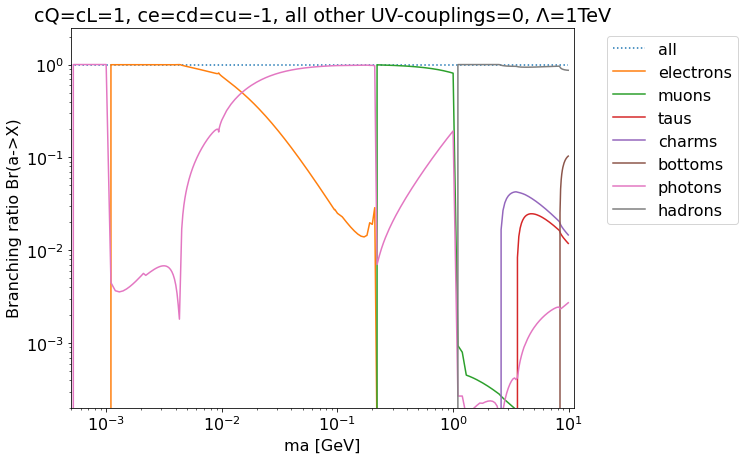

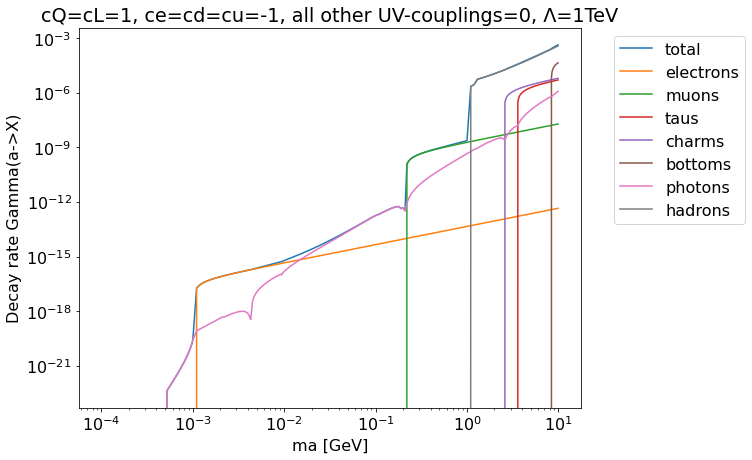

In [57]:
brsALP(1,-1,-1,1,-1,0,0,0,"cQ=cL=1, ce=cd=cu=-1, all other UV-couplings=0, \u039B=1TeV",1000)
brsALP(1,-1,-1,1,-1,0,0,0,"cQ=cL=1, ce=cd=cu=-1, all other UV-couplings=0, \u039B=1TeV",1000,br=False)

<ipython-input-19-de56bdf3d9c0>:46: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)
<ipython-input-19-de56bdf3d9c0>:109: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)


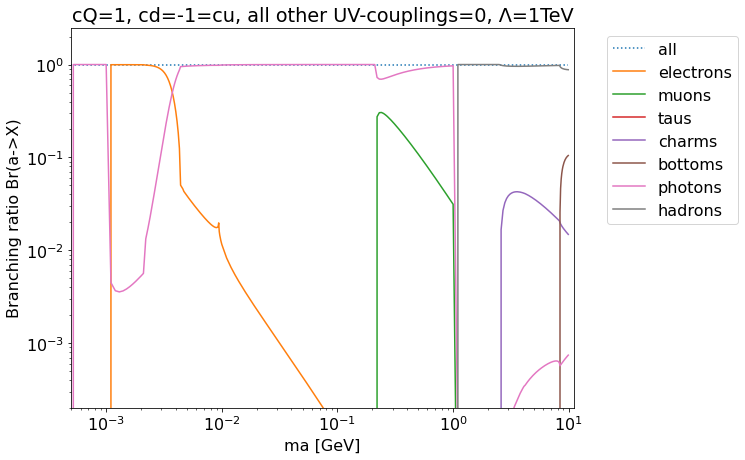

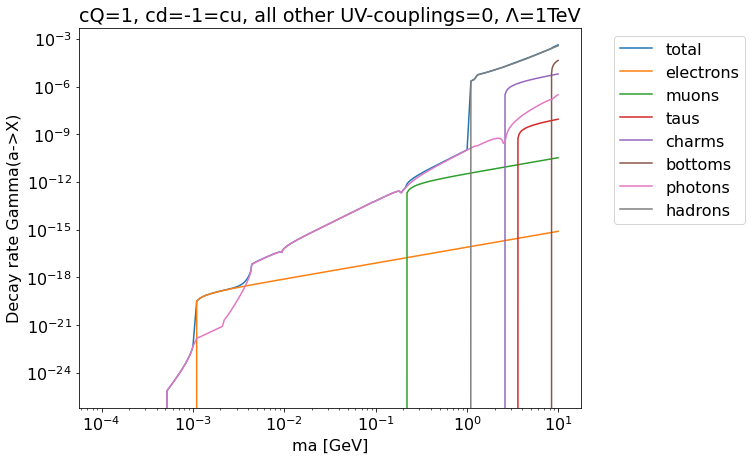

In [58]:
brsALP(1,-1,-1,0,0,0,0,0,"cQ=1, cd=-1=cu, all other UV-couplings=0, \u039B=1TeV",1000)
brsALP(1,-1,-1,0,0,0,0,0,"cQ=1, cd=-1=cu, all other UV-couplings=0, \u039B=1TeV",1000,br=False)

## Integral over detector

In [35]:
def gammaBeta(gammaParent,mParent,ma):
    return np.sqrt(gammaParent**2 * (sm['mB+']**2-sm['mK+']**2+ma**2)**2/(4*sm['mB+']**2*ma**2)-1)
    
def gammaBetaAlp(ma):
    return gammaBeta(BelleIIparams['gammaBoostB'],sm['mB+'],ma)

In [36]:
def thetaMinBoost(thetaMin,r,ctau,gammaBeta):
    return np.arctan(r/(r/np.tan(thetaMin) - gammaBeta * ctau))

def thetaMaxBoost(thetaMin,r,ctau,gammaBeta):
    return np.pi+np.arctan(-r/(-r/np.tan(thetaMin) + gammaBeta * ctau))

def geomInt(thetaMin,thetaMax,dmin,dmax,ctau,gammaBeta):
    return 1/(4 * (gammaBeta * ctau)**2) * integrate.quad(lambda theta: (1/np.sin(theta)) \
            * (np.exp(-dmin/(np.sin(theta) * gammaBeta * ctau)) * (dmin**2 + 2 * gammaBeta * ctau * np.sin(theta) \
            * (dmin + gammaBeta * ctau * np.sin(theta)))\
            - np.exp(-dmax/(np.sin(theta) * gammaBeta * ctau)) * (dmax**2 + 2 * gammaBeta * ctau * np.sin(theta) \
            * (dmax + gammaBeta * ctau * np.sin(theta))))\
            , thetaMin, thetaMax)[0]
    
def geomIntBelleIICDC(thetaMin,thetaMax,dmin,dmax,ctau,gammaBeta):
    return np.heaviside(np.real(BelleIIparams['RCDC']/np.tan(thetaMin)-BelleIIparams['gammaBoostB'] * sm['ctauB+']),1)\
            * geomInt(thetaMin,thetaMax,dmin,dmax,ctau,gammaBeta)
                                                

In [37]:
geomInt(np.deg2rad(17),np.deg2rad(150),0.9,1.1,0.5,1.7)

0.06484569710142005

In [38]:
geomIntBelleIICDC(np.deg2rad(17),np.deg2rad(150),0.9,60,0.5,1.7)

0.7661607320676481

In [39]:
thetaMinBoost(np.deg2rad(17),0.9,0.5,1.7)

0.40596908074511884

In [40]:
thetaMaxBoost(np.deg2rad(17),0.9,0.5,1.7)

3.547561734334912

# Number of signal events

In [41]:
BelleIIparams={
    'gammaBoostB': 1.03029,
    'RCDC': 60, #cm
    'thetaCDCMin': np.deg2rad(17),
    'thetaCDCMax': np.deg2rad(150),
    'dres': 0.9,
    'NBBelleII': 5*10**10
}

In [42]:
def nsignalBelleII(ma,finalStateCode,cQ,cu,cd,cL,ce,cGG,cWW,cBB,Lambda):
    with HiddenPrints():
        HC = OrderedDict()
        HC['Q'] = np.array([[cQ,0,0],[0,cQ,0],[0,0,cQ]])
        HC['u'] = np.array([[cu,0,0],[0,cu,0],[0,0,cu]])
        HC['d'] = np.array([[cd,0,0],[0,cd,0],[0,0,cd]])
        HC['L'] = np.array([[cL,0,0],[0,cL,0],[0,0,cL]])
        HC['e'] = np.array([[ce,0,0],[0,ce,0],[0,0,ce]])
        HC['GG'] = cGG
        HC['WW'] = cWW
        HC['BB'] = cBB
        
        lscsTmp = TdAlps.RunRotateMatchRun(HC, Lambda, sm['mB+'], 3)
        
        cbs=readCbs(lscsTmp)#getCbs(cff, cWW, cBB, Lambda, sm['mB+'])
        
#     print("BR(B-> K+ a)= ",BrBtoKaplus(ma, cbs, Lambda))    
    
#     #rewrite brALPtoOneFinalState such that last agr can be not a None 
#     print("BR(a->final)= ",brALPtoOneFinalState(ma,finalStateCode,cQ,cu,cd,cL,ce,cGG,cWW,cBB,Lambda,None)[0])
    
#     print([thetaMinBoost(BelleIIparams['thetaCDCMin'],BelleIIparams['RCDC'],sm['ctauB+']\
#     ,gammaBetaAlp(ma)),thetaMaxBoost(BelleIIparams['thetaCDCMax'],BelleIIparams['RCDC'],sm['ctauB+']\
#     ,gammaBetaAlp(ma)),BelleIIparams['dres'],BelleIIparams['RCDC']\
#     ,brALPtoOneFinalState(ma,finalStateCode,cQ,cu,cd,cL,ce,cGG,cWW,cBB,Lambda,None)[1],gammaBetaAlp(ma)])
    
#     print(geomIntBelleIICDC(thetaMinBoost(BelleIIparams['thetaCDCMin'],BelleIIparams['RCDC'],sm['ctauB+']\
#     ,gammaBetaAlp(ma)),thetaMaxBoost(BelleIIparams['thetaCDCMax'],BelleIIparams['RCDC'],sm['ctauB+']\
#     ,gammaBetaAlp(ma)),BelleIIparams['dres'],BelleIIparams['RCDC']\
#     ,brALPtoOneFinalState(ma,finalStateCode,cQ,cu,cd,cL,ce,cGG,cWW,cBB,Lambda,None)[1],gammaBetaAlp(ma)))
    
    return BelleIIparams['NBBelleII'] * BrBtoKaplus(ma, cbs, Lambda) \
    * brALPtoOneFinalState(ma,finalStateCode,cQ,cu,cd,cL,ce,cGG,cWW,cBB,Lambda,None)[0]\
    * geomIntBelleIICDC(thetaMinBoost(BelleIIparams['thetaCDCMin'],BelleIIparams['RCDC'],sm['ctauB+']\
    ,gammaBetaAlp(ma)),thetaMaxBoost(BelleIIparams['thetaCDCMax'],BelleIIparams['RCDC'],sm['ctauB+']\
    ,gammaBetaAlp(ma)),BelleIIparams['dres'],BelleIIparams['RCDC']\
    ,brALPtoOneFinalState(ma,finalStateCode,cQ,cu,cd,cL,ce,cGG,cWW,cBB,Lambda,None)[1],gammaBetaAlp(ma))

In [43]:
nsignalBelleII(0.2,5,1,-1,-1,1,-1,0,0,0,1000)

<ipython-input-19-de56bdf3d9c0>:46: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)


8422533143.760596

In [44]:
geomIntBelleIICDC(0.2968886712976968, 2.6185273888027787, 0.9, 60, 8.981305682648816e-06, 2.6080796979823226)

0.0

In [45]:

def nsignalAt95CLBelleIIAllcEqual(cff,ma,finalStateCode,Lambda,nOfEventsAt95CL):
    cQ=cL=cWW=cBB=cff
    ce=cd=cu=-cff
    cGG=0
    return nsignalBelleII(ma,finalStateCode,cQ,cu,cd,cL,ce,cGG,cWW,cBB,Lambda)-nOfEventsAt95CL

def nsignalAt95CLBelleIIcff(cff,ma,finalStateCode,Lambda,nOfEventsAt95CL):
    cGG=cWW=cBB=0
    cQ=cL=cff
    ce=cd=cu=-cff
    return nsignalBelleII(ma,finalStateCode,cQ,cu,cd,cL,ce,cGG,cWW,cBB,Lambda)-nOfEventsAt95CL


# def nsignalAt95CLBelleIIcWW(cWW,ma,finalStateCode,Lambda,nOfEventsAt95CL):
#     cQ=cL=cu=cd=ce=cGG=cBB=0
#     res = []
#     for i in np.asarray(cWW):
#         res_i = nsignalBelleII(ma,finalStateCode,cQ,cu,cd,cL,ce,cGG,i,cBB,Lambda)-nOfEventsAt95CL
#         res.append(res_i)
#     return np.array(res)

def nsignalAt95CLBelleIIcWW(cWW,ma,finalStateCode,Lambda,nOfEventsAt95CL):
    cQ=cL=cu=cd=ce=cGG=cBB=0
    return nsignalBelleII(ma,finalStateCode,cQ,cu,cd,cL,ce,cGG,cWW,cBB,Lambda)-nOfEventsAt95CL

In [46]:
nsignalAt95CLBelleIIAllcEqual(1,0.1,5,10**3,3)

<ipython-input-19-de56bdf3d9c0>:46: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)


12186351608.862116

In [47]:
nsignalBelleII(0.1,5,1,-1,-1,1,-1,0,1,1,10**3)

<ipython-input-19-de56bdf3d9c0>:46: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)


12186351611.862116

#### decays under consideration encoded as
0: e
1: mu
2: tau
3: charm
4: bottom
5: photon
6: hadron

In [140]:
couplingList=np.logspace(-6, 4, 20)
def visibleBoundBelleIIcffEqcWWEqcBB(ma,finalStateCode,Lambda,nOfEventsAt95CL):
    nsignalAt95CLBelleIIAllcEqualEstimate=np.vstack(([coupling,nsignalAt95CLBelleIIAllcEqual(\
                    coupling,ma,finalStateCode,Lambda,nOfEventsAt95CL)] for coupling in couplingList))
    
#     print([nsignalAt95CLBelleIIAllcEqual(couplingList[0],ma,finalStateCode,Lambda,nOfEventsAt95CL),\
#           nsignalAt95CLBelleIIAllcEqual(nsignalAt95CLBelleIIAllcEqualEstimate[\
#         np.argmax(nsignalAt95CLBelleIIAllcEqualEstimate[:,1]>0),0],ma,finalStateCode,Lambda,nOfEventsAt95CL)])
    
    if (np.argmax(nsignalAt95CLBelleIIAllcEqualEstimate[:,1]>0)==0):
        root1=root2=np.nan
    else:
        root1=optimize.brentq(nsignalAt95CLBelleIIAllcEqual, couplingList[0],\
            nsignalAt95CLBelleIIAllcEqualEstimate[np.argmax(nsignalAt95CLBelleIIAllcEqualEstimate[:,1]>0),0],\
                          args = (ma,finalStateCode,Lambda,nOfEventsAt95CL))

        root2=optimize.brentq(nsignalAt95CLBelleIIAllcEqual,\
            nsignalAt95CLBelleIIAllcEqualEstimate[np.argmax(nsignalAt95CLBelleIIAllcEqualEstimate[:,1]>0),0],\
                              couplingList[-1], args = (ma,finalStateCode,Lambda,nOfEventsAt95CL))
    return [root1,root2]

def visibleBoundBelleIIcff(ma,finalStateCode,Lambda,nOfEventsAt95CL):
    nsignalAt95CLBelleIIcffEstimate=np.vstack(([coupling,nsignalAt95CLBelleIIcff(coupling,ma,finalStateCode,\
                                                Lambda,nOfEventsAt95CL)] for coupling in couplingList))
    if (np.argmax(nsignalAt95CLBelleIIcffEstimate[:,1]>0)==0):
        root1=root2=np.nan
    else:
        root1=optimize.brentq(nsignalAt95CLBelleIIcff, couplingList[0],\
            nsignalAt95CLBelleIIcffEstimate[np.argmax(nsignalAt95CLBelleIIcffEstimate[:,1]>0),0],\
                          args = (ma,finalStateCode,Lambda,nOfEventsAt95CL))

        root2=optimize.brentq(nsignalAt95CLBelleIIcff,\
            nsignalAt95CLBelleIIcffEstimate[np.argmax(nsignalAt95CLBelleIIcffEstimate[:,1]>0),0],\
                              couplingList[-1], args = (ma,finalStateCode,Lambda,nOfEventsAt95CL))
    return [root1,root2]

def visibleBoundBelleIIcWW(ma,finalStateCode,Lambda,nOfEventsAt95CL):
    nsignalAt95CLBelleIIcWWEstimate=np.vstack(([coupling,nsignalAt95CLBelleIIcWW(coupling,ma,finalStateCode,\
                                                Lambda,nOfEventsAt95CL)] for coupling in couplingList))
#     print(nsignalAt95CLBelleIIcWWEstimate)
    if (np.argmax(nsignalAt95CLBelleIIcWWEstimate[:,1]>0)==0):
        root1=root2=np.nan
    else:
        root1=optimize.brentq(nsignalAt95CLBelleIIcWW, couplingList[0],\
            nsignalAt95CLBelleIIcWWEstimate[np.argmax(nsignalAt95CLBelleIIcWWEstimate[:,1]>0),0],\
                          args = (ma,finalStateCode,Lambda,nOfEventsAt95CL))

        root2=optimize.brentq(nsignalAt95CLBelleIIcWW,\
            nsignalAt95CLBelleIIcWWEstimate[np.argmax(nsignalAt95CLBelleIIcWWEstimate[:,1]>0),0],\
                              couplingList[-1], args = (ma,finalStateCode,Lambda,nOfEventsAt95CL))
    return [root1,root2]
    

In [65]:
visibleBoundBelleIIcWW(1,5,10**3,3)

<ipython-input-48-2b61bc1373f6>:38: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  nsignalAt95CLBelleIIcWWEstimate=np.vstack(([coupling,nsignalAt95CLBelleIIcWW(coupling,ma,finalStateCode,\
<ipython-input-19-de56bdf3d9c0>:46: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)
<ipython-input-36-1f1779c84ac1>:8: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return 1/(4 * (gammaBeta * ctau)**2) * integrate.quad(lambda theta: (1/np.sin(theta)) \
<ipython-input-36-1f1779c84ac1>:8: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (s

[0.009456786685087402, 0.33908459210026265]

In [ ]:
# visibleBoundBelleIIcffEqcWWEqcBB(0.05,5,10**3,3)

In [50]:
visibleBoundBelleIIcff(0.01,5,10**3,3)

<ipython-input-48-2b61bc1373f6>:23: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  nsignalAt95CLBelleIIcffEstimate=np.vstack(([coupling,nsignalAt95CLBelleIIcff(coupling,ma,finalStateCode,\
<ipython-input-19-de56bdf3d9c0>:46: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)
<ipython-input-36-1f1779c84ac1>:8: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return 1/(4 * (gammaBeta * ctau)**2) * integrate.quad(lambda theta: (1/np.sin(theta)) \
<ipython-input-36-1f1779c84ac1>:8: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (s

[0.5337758597390725, 617.7099326649783]

In [108]:
#masslist= [0.05, 0.05, 0.1, 0.2, 0.3, 0.5, 1., 2., 4.]
masslist=np.sort(np.append(np.logspace(-2, 0, 25),[0.101, 0.43, 0.47, 0.95, 1, 1.5, 2, 2.5, 3, 3.2, 3.5, 4]))
particleCodes=[*range(0,7,1)]

In [109]:
masslist

array([0.01      , 0.01211528, 0.01467799, 0.01778279, 0.02154435,
       0.02610157, 0.03162278, 0.03831187, 0.04641589, 0.05623413,
       0.06812921, 0.08254042, 0.1       , 0.101     , 0.12115277,
       0.14677993, 0.17782794, 0.21544347, 0.26101572, 0.31622777,
       0.38311868, 0.43      , 0.46415888, 0.47      , 0.56234133,
       0.68129207, 0.82540419, 0.95      , 1.        , 1.        ,
       1.5       , 2.        , 2.5       , 3.        , 3.2       ,
       3.5       , 4.        ])

In [52]:
masslist[6:]

array([ 0.05623413,  0.07498942,  0.1       ,  0.13335214,  0.17782794,
        0.23713737,  0.31622777,  0.4216965 ,  0.56234133,  0.74989421,
        1.        ,  1.33352143,  1.77827941,  2.37137371,  3.16227766,
        4.21696503,  5.62341325,  7.49894209, 10.        ])

### mapping bounds over masses and final states

In [110]:
listVisibleBoundBelleIIcffEqcWWEqcBB=[]
for mass in masslist:
    listForFixedMass=[]
    for particle in particleCodes:
        listForFixedMass.append(visibleBoundBelleIIcffEqcWWEqcBB(mass,particle,10**3,3))
    listVisibleBoundBelleIIcffEqcWWEqcBB.append(listForFixedMass)
arrayVisibleBoundBelleIIcffEqcWWEqcBB=np.array(listVisibleBoundBelleIIcffEqcWWEqcBB)

<ipython-input-48-2b61bc1373f6>:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  nsignalAt95CLBelleIIAllcEqualEstimate=np.vstack(([coupling,nsignalAt95CLBelleIIAllcEqual(\
<ipython-input-19-de56bdf3d9c0>:46: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)
<ipython-input-36-1f1779c84ac1>:8: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return 1/(4 * (gammaBeta * ctau

In [111]:
listVisibleBoundBelleIIcff=[]
for mass in masslist:
    listForFixedMass=[]
    for particle in particleCodes:
        listForFixedMass.append(visibleBoundBelleIIcff(mass,particle,10**3,3))
    listVisibleBoundBelleIIcff.append(listForFixedMass)
arrayVisibleBoundBelleIIcff=np.array(listVisibleBoundBelleIIcff)

<ipython-input-48-2b61bc1373f6>:23: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  nsignalAt95CLBelleIIcffEstimate=np.vstack(([coupling,nsignalAt95CLBelleIIcff(coupling,ma,finalStateCode,\
<ipython-input-19-de56bdf3d9c0>:46: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)
<ipython-input-36-1f1779c84ac1>:8: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return 1/(4 * (gammaBeta * ctau)**2) * integrate.quad(lambda theta: (1/np.sin(theta)) \
<ipython-input-36-1f1779c84ac1>:8: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (s

In [141]:
visibleBoundBelleIIcWW(0.021544346900318832,5,10**3,3)

<ipython-input-140-d5f8338667dc>:38: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  nsignalAt95CLBelleIIcWWEstimate=np.vstack(([coupling,nsignalAt95CLBelleIIcWW(coupling,ma,finalStateCode,\
<ipython-input-19-de56bdf3d9c0>:46: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)
<ipython-input-36-1f1779c84ac1>:8: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return 1/(4 * (gammaBeta * ctau)**2) * integrate.quad(lambda theta: (1/np.sin(theta)) \
<ipython-input-36-1f1779c84ac1>:8: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (

[2.730636431734552, 1120.0072212236569]

In [142]:
listVisibleBoundBelleIIcWW=[]
for mass in masslist[4:]:
    listForFixedMass=[]
    for particle in particleCodes:
#         print(mass,particle)
        listForFixedMass.append(visibleBoundBelleIIcWW(mass,particle,10**3,3))
    listVisibleBoundBelleIIcWW.append(listForFixedMass)
arrayVisibleBoundBelleIIcWW=np.array(listVisibleBoundBelleIIcWW)

<ipython-input-140-d5f8338667dc>:38: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  nsignalAt95CLBelleIIcWWEstimate=np.vstack(([coupling,nsignalAt95CLBelleIIcWW(coupling,ma,finalStateCode,\
<ipython-input-19-de56bdf3d9c0>:46: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)
<ipython-input-36-1f1779c84ac1>:8: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return 1/(4 * (gammaBeta * ctau)**2) * integrate.quad(lambda theta: (1/np.sin(theta)) \
<ipython-input-36-1f1779c84ac1>:8: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (

In [113]:
arrayVisibleBoundBelleIIcffEqcWWEqcBB

array([[[4.43439932e-01, 5.66531157e+02],
        [           nan,            nan],
        [           nan,            nan],
        [           nan,            nan],
        [           nan,            nan],
        [4.70542927e-01, 5.62897183e+02],
        [           nan,            nan]],

       [[3.59732297e-01, 4.05472996e+02],
        [           nan,            nan],
        [           nan,            nan],
        [           nan,            nan],
        [           nan,            nan],
        [3.55404562e-01, 4.06015313e+02],
        [           nan,            nan]],

       [[2.91415751e-01, 2.89190945e+02],
        [           nan,            nan],
        [           nan,            nan],
        [           nan,            nan],
        [           nan,            nan],
        [2.71902374e-01, 2.91458717e+02],
        [           nan,            nan]],

       [[2.35208015e-01, 2.04554790e+02],
        [           nan,            nan],
        [           nan,    

In [114]:
listVisibleBoundBelleIIcff

[[[0.4659577946381072, 626.8647898574698],
  [nan, nan],
  [nan, nan],
  [nan, nan],
  [nan, nan],
  [0.5337758597390725, 617.7099326649783],
  [nan, nan]],
 [[0.38484809865476854, 466.05034344295757],
  [nan, nan],
  [nan, nan],
  [nan, nan],
  [nan, nan],
  [0.40919439197361973, 462.9242769215577],
  [nan, nan]],
 [[0.31712742144346756, 344.67624531732076],
  [nan, nan],
  [nan, nan],
  [nan, nan],
  [nan, nan],
  [0.3186078182188146, 344.49729487667383],
  [nan, nan]],
 [[0.2599573847024593, 252.00605570223007],
  [nan, nan],
  [nan, nan],
  [nan, nan],
  [nan, nan],
  [0.2482976679754299, 253.3230831090265],
  [nan, nan]],
 [[0.2118598416653347, 181.92573080443916],
  [nan, nan],
  [nan, nan],
  [nan, nan],
  [nan, nan],
  [0.19293031665603158, 183.91107140007142],
  [nan, nan]],
 [[0.17167821582359435, 129.6940529392911],
  [nan, nan],
  [nan, nan],
  [nan, nan],
  [nan, nan],
  [0.14925930579324756, 131.86517307651062],
  [nan, nan]],
 [[0.1383856181770438, 91.37994231442734],
  

In [144]:
listVisibleBoundBelleIIcWW

[[[14.653675353493785, 814.1159220443234],
  [nan, nan],
  [nan, nan],
  [nan, nan],
  [nan, nan],
  [2.730636431734552, 1120.0072212236569],
  [nan, nan]],
 [[11.764599383601563, 531.0678816293151],
  [nan, nan],
  [nan, nan],
  [nan, nan],
  [nan, nan],
  [2.0497344707002103, 752.6840014372358],
  [nan, nan]],
 [[9.52357725195511, 344.72729483647464],
  [nan, nan],
  [nan, nan],
  [nan, nan],
  [nan, nan],
  [1.5378063024848159, 505.609201759485],
  [nan, nan]],
 [[7.807567144256682, 222.31400799839528],
  [nan, nan],
  [nan, nan],
  [nan, nan],
  [nan, nan],
  [1.1538487731039027, 339.4998346681105],
  [nan, nan]],
 [[6.535429532815657, 142.1845192979698],
  [nan, nan],
  [nan, nan],
  [nan, nan],
  [nan, nan],
  [0.8658646966228285, 227.8376185479614],
  [nan, nan]],
 [[5.690735166081582, 89.80542151474388],
  [nan, nan],
  [nan, nan],
  [nan, nan],
  [nan, nan],
  [0.6498559632330398, 152.86398892380706],
  [nan, nan]],
 [[5.463290222369208, 55.66233870169897],
  [nan, nan],
  [na

### saving bounds to files

In [145]:
# with open('output/masslist.csv', 'w') as f:
#    ww = csv.writer(f, delimiter=',')
#    ww.writerows(masslist) 
    
with open('output/visibleBoundBelleIIcffEqcWWEqcBB.csv', 'w') as f:
   ww = csv.writer(f, delimiter=',')
   ww.writerows(listVisibleBoundBelleIIcffEqcWWEqcBB) 
    
with open('output/visibleBoundBelleIIcff.csv', 'w') as f:
   ww = csv.writer(f, delimiter=',')
   ww.writerows(listVisibleBoundBelleIIcff) 
    
with open('output/visibleBoundBelleIIcWW.csv', 'w') as f:
   ww = csv.writer(f, delimiter=',')
   ww.writerows(listVisibleBoundBelleIIcWW) 

### plots

#### decays under consideration encoded as
0: e
1: mu
2: tau
3: charm
4: bottom
5: photon
6: hadron

In [116]:
def plotBounds(boundsArray, particleCode, upper=False):
    if upper:
        return np.vstack([np.array(masslist),boundsArray[:,particleCode,1]]).T
    else:
        return np.vstack([np.array(masslist),boundsArray[:,particleCode,0]]).T

<ipython-input-19-de56bdf3d9c0>:46: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)
<ipython-input-19-de56bdf3d9c0>:109: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)


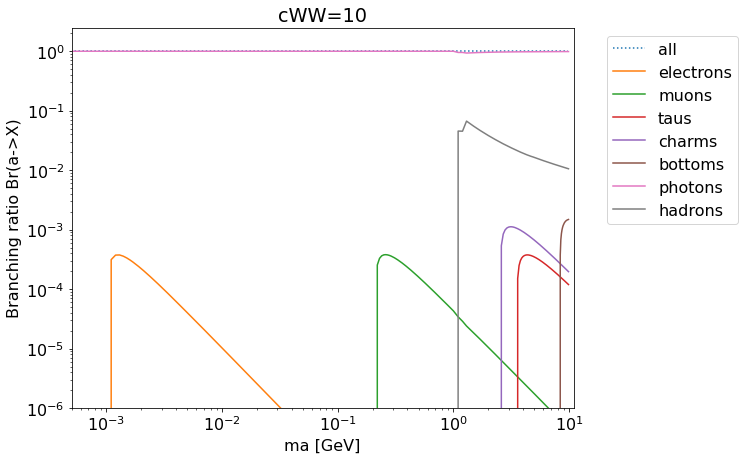

<ipython-input-159-7527a81cdd2e>:10: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "Xbbox_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  figBRcWW.savefig('plots/cWW={}'.format(cffPlot), dpi=300, Xbbox_inches='tight')


In [159]:
cffPlot=1
cWWPlot=10


# figBRcffEqcWWEqcBB=brsALP(cffPlot,-cffPlot,-cffPlot,cffPlot,-cffPlot,0,cffPlot,cffPlot,\
#                           'cff=cWW=cBB={}'.format(cffPlot),10**3)
# figBRcffEqcWWEqcBB.savefig('plots/cff=cWW=cBB={}'.format(cffPlot), dpi=300, bbox_inches='tight')

figBRcWW=brsALP(0,0,0,0,0,0,cWWPlot,0,'cWW={}'.format(cWWPlot),10**3)
figBRcWW.savefig('plots/cWW={}'.format(cffPlot), dpi=300, Xbbox_inches='tight')

# figBRcff=brsALP(cffPlot,-cffPlot,-cffPlot,cffPlot,-cffPlot,0,0,0,'cff={}'.format(cffPlot),10**3)
# figBRcff.savefig('plotscff={}'.format(cffPlot), dpi=300, bbox_inches='tight')


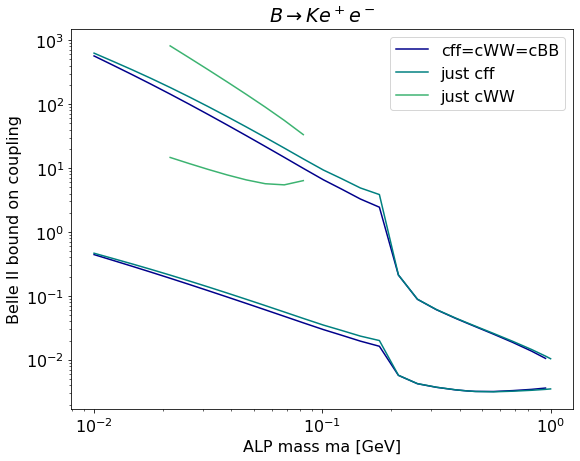

In [146]:
fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(masslist,arrayVisibleBoundBelleIIcffEqcWWEqcBB[:,0,0],label='cff=cWW=cBB',c="darkblue") 
ax.plot(masslist,arrayVisibleBoundBelleIIcffEqcWWEqcBB[:,0,1],c="darkblue") 

ax.plot(masslist,arrayVisibleBoundBelleIIcff[:,0,0],label='just cff',c="teal") 
ax.plot(masslist,arrayVisibleBoundBelleIIcff[:,0,1],c="teal") 

ax.plot(masslist[4:],arrayVisibleBoundBelleIIcWW[:,0,0],label='just cWW',c="mediumseagreen") 
ax.plot(masslist[4:],arrayVisibleBoundBelleIIcWW[:,0,1],c="mediumseagreen") 

# ax.plot(masses,boundsCffZero,label='just cff', ls='--') 
# ax.plot(masses,boundsCWWZero,label='just cWW', ls=':') 
# ax.plot(masses,boundsCBBZero,label='just cBB', ls='-.') 

ax.set_title('$B\\rightarrow K e^+ e^-$')

ax.set_xlabel('ALP mass ma [GeV]')
ax.set_ylabel('Belle II bound on coupling')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

plt.savefig('plots/visibleBoundBelleII-electrons.png', dpi=300, bbox_inches='tight')

In [147]:
visibleBoundBelleIIcWW(0.101,0,10**3,3)

<ipython-input-140-d5f8338667dc>:38: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  nsignalAt95CLBelleIIcWWEstimate=np.vstack(([coupling,nsignalAt95CLBelleIIcWW(coupling,ma,finalStateCode,\
<ipython-input-19-de56bdf3d9c0>:46: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)
<ipython-input-36-1f1779c84ac1>:8: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return 1/(4 * 

[nan, nan]

In [148]:
visibleBoundBelleIIcffEqcWWEqcBB(0.95,0,10**3,3)

<ipython-input-140-d5f8338667dc>:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  nsignalAt95CLBelleIIAllcEqualEstimate=np.vstack(([coupling,nsignalAt95CLBelleIIAllcEqual(\
<ipython-input-19-de56bdf3d9c0>:46: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)
<ipython-input-36-1f1779c84ac1>:8: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return 1/(4 * (gammaBeta * cta

[0.0036281323287399463, 0.010557913762586135]

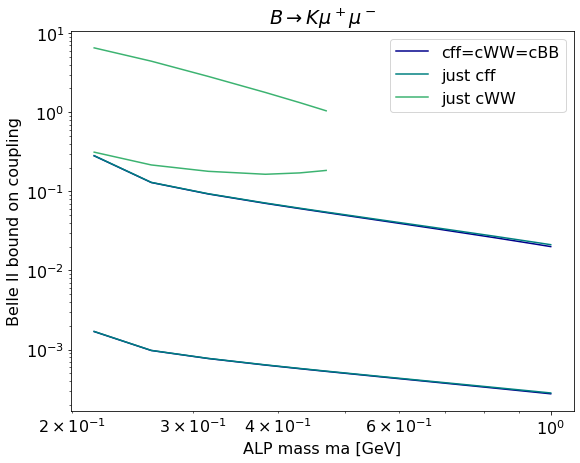

In [149]:
fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(masslist,arrayVisibleBoundBelleIIcffEqcWWEqcBB[:,1,0],label='cff=cWW=cBB',c="darkblue") 
ax.plot(masslist,arrayVisibleBoundBelleIIcffEqcWWEqcBB[:,1,1],c="darkblue") 

ax.plot(masslist,arrayVisibleBoundBelleIIcff[:,1,0],label='just cff',c="teal") 
ax.plot(masslist,arrayVisibleBoundBelleIIcff[:,1,1],c="teal") 

ax.plot(masslist[4:],arrayVisibleBoundBelleIIcWW[:,1,0],label='just cWW',c="mediumseagreen") 
ax.plot(masslist[4:],arrayVisibleBoundBelleIIcWW[:,1,1],c="mediumseagreen") 

# ax.plot(masses,boundsCffZero,label='just cff', ls='--') 
# ax.plot(masses,boundsCWWZero,label='just cWW', ls=':') 
# ax.plot(masses,boundsCBBZero,label='just cBB', ls='-.') 

ax.set_title('$B\\rightarrow K \\mu^+ \\mu^-$')

ax.set_xlabel('ALP mass ma [GeV]')
ax.set_ylabel('Belle II bound on coupling')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

plt.savefig('plots/visibleBoundBelleII-muons.png', dpi=300, bbox_inches='tight')

In [80]:
visibleBoundBelleIIcff(2,1,10**3,3)

<ipython-input-48-2b61bc1373f6>:23: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  nsignalAt95CLBelleIIcffEstimate=np.vstack(([coupling,nsignalAt95CLBelleIIcff(coupling,ma,finalStateCode,\
<ipython-input-19-de56bdf3d9c0>:46: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)
<ipython-input-19-de56bdf3d9c0>:109: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)


[nan, nan]

In [83]:
visibleBoundBelleIIcWW(0.47,1,10**3,3)

<ipython-input-48-2b61bc1373f6>:38: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  nsignalAt95CLBelleIIcWWEstimate=np.vstack(([coupling,nsignalAt95CLBelleIIcWW(coupling,ma,finalStateCode,\
<ipython-input-19-de56bdf3d9c0>:46: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)
<ipython-input-36-1f1779c84ac1>:8: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return 1/(4 * (gammaBeta * ctau)**2) * integrate.quad(lambda theta: (1/np.sin(theta)) \
<ipython-input-36-1f1779c84ac1>:8: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (s

[0.1840921213400842, 1.043472491404147]

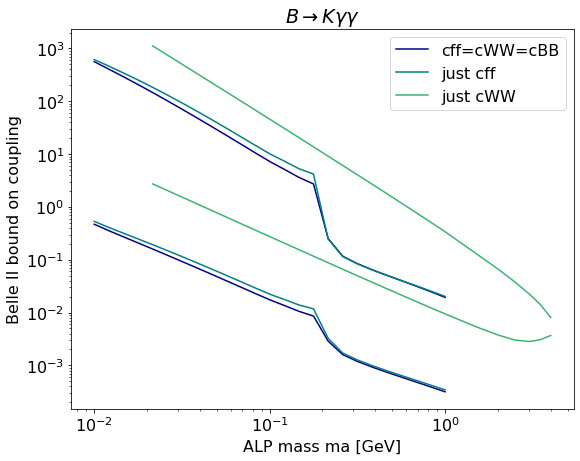

In [150]:
fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(masslist,arrayVisibleBoundBelleIIcffEqcWWEqcBB[:,5,0],label='cff=cWW=cBB',c="darkblue") 
ax.plot(masslist,arrayVisibleBoundBelleIIcffEqcWWEqcBB[:,5,1],c="darkblue") 

ax.plot(masslist,arrayVisibleBoundBelleIIcff[:,5,0],label='just cff',c="teal") 
ax.plot(masslist,arrayVisibleBoundBelleIIcff[:,5,1],c="teal") 

ax.plot(masslist[4:],arrayVisibleBoundBelleIIcWW[:,5,0],label='just cWW',c="mediumseagreen") 
ax.plot(masslist[4:],arrayVisibleBoundBelleIIcWW[:,5,1],c="mediumseagreen") 

# ax.plot(masses,boundsCffZero,label='just cff', ls='--') 
# ax.plot(masses,boundsCWWZero,label='just cWW', ls=':') 
# ax.plot(masses,boundsCBBZero,label='just cBB', ls='-.') 

ax.set_title('$B\\rightarrow K \\gamma \\gamma$')

ax.set_xlabel('ALP mass ma [GeV]')
ax.set_ylabel('Belle II bound on coupling')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

plt.savefig('plots/visibleBoundBelleII-photons.png', dpi=300, bbox_inches='tight')

In [104]:
visibleBoundBelleIIcWW(4,5,10**3,3)

<ipython-input-48-2b61bc1373f6>:38: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  nsignalAt95CLBelleIIcWWEstimate=np.vstack(([coupling,nsignalAt95CLBelleIIcWW(coupling,ma,finalStateCode,\
<ipython-input-19-de56bdf3d9c0>:46: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)
<ipython-input-19-de56bdf3d9c0>:109: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)
<ipython-input-36-1f1779c84ac1>:8: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return 1/(4 * (gammaBeta * ctau)**2) * integrate.quad(lambda theta: (1/np.sin(theta)) \
<ipython-input-36-1f1779c84ac1>:8: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The err

[nan, nan]